# Бэггинг и случайный лес

Загрузите датасет digits с помощью функции load_digits из sklearn.datasets и подготовьте матрицу признаков X и ответы на обучающей выборке y (вам потребуются поля data и target в объекте, который возвращает load_digits).
Для оценки качества далее нужно будет использовать cross_val_score из sklearn.cross_validation с параметром cv=10. Эта функция реализует k-fold cross validation c k равным значению параметра cv. Функция cross_val_score будет возвращать numpy.ndarray, в котором будет k чисел - качество в каждом из k экспериментов k-fold cross validation. Для получения среднего значения (которое и будет оценкой качества работы) вызовите метод .mean() у массива, который возвращает cross_val_score.

Если вам захочется ускорить вычисление cross_val_score - можете попробовать использовать параметр n_jobs.

In [9]:
%matplotlib inline
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn

In [10]:

digits = datasets.load_digits()
X = digits.data
y = digits.target


### Шаг 1
Создайте DecisionTreeClassifier с настройками по умолчанию и измерьте качество его работы с помощью cross_val_score.

In [11]:
from sklearn.model_selection import cross_val_score

clf = DecisionTreeClassifier()
cross_val_score(clf, X, y, cv=10)

array([0.77222222, 0.85      , 0.82222222, 0.80555556, 0.78333333,
       0.88333333, 0.88888889, 0.81005587, 0.83240223, 0.79888268])

### Шаг 2

Воспользуйтесь BaggingClassifier из sklearn.ensemble, чтобы обучить бэггинг над DecisionTreeClassifier. Используйте в BaggingClassifier параметры по умолчанию, задав только количество деревьев равным 100.

In [12]:
bclf = BaggingClassifier(clf, n_estimators=100)
cross_val_score(bclf, X, y, cv=10)

array([0.87222222, 0.94444444, 0.90555556, 0.91666667, 0.91111111,
       0.98888889, 0.96666667, 0.91061453, 0.87150838, 0.91620112])

### Шаг 3
Теперь изучите параметры BaggingClassifier и выберите их такими, чтобы каждый базовый алгоритм обучался не на всех d признаках, а на $\sqrt{d}$ случайных признаков. Корень из числа признаков - часто используемая эвристика в задачах классификации, в задачах регрессии же часто берут число признаков, деленное на три. Но в общем случае ничто не мешает вам выбирать любое другое число случайных признаков.

In [13]:

feature_num = X.shape[1]
bclf_sqrt = BaggingClassifier(clf, max_features=int(np.sqrt(feature_num)), n_estimators=100)
cross_val_score(bclf, X, y, cv=10)


array([0.87222222, 0.96666667, 0.92222222, 0.91111111, 0.93333333,
       0.98333333, 0.95555556, 0.91620112, 0.87150838, 0.93296089])

### Шаг 4
Наконец, давайте попробуем выбирать случайные признаки не один раз на все дерево, а при построении каждой вершины дерева. Сделать это несложно: нужно убрать выбор случайного подмножества признаков в BaggingClassifier и добавить его в DecisionTreeClassifier. Какой параметр за это отвечает, можно понять из документации sklearn, либо просто попробовать угадать (скорее всего, у вас сразу получится). Попробуйте выбирать опять же $\sqrt{d}$ признаков.

In [14]:

global_feature_num = X.shape[1]
clf = DecisionTreeClassifier(max_features=int(np.sqrt(global_feature_num)))
bclf_random = BaggingClassifier(clf, n_estimators=100)
cross_val_score(bclf_random, X, y, cv=10)


array([0.91111111, 0.97222222, 0.92777778, 0.93888889, 0.96666667,
       0.98333333, 0.97777778, 0.97206704, 0.93296089, 0.94413408])

### Шаг 5

Полученный в пункте 4 классификатор - бэггинг на рандомизированных деревьях (в которых при построении каждой вершины выбирается случайное подмножество признаков и разбиение ищется только по ним). Это в точности соответствует алгоритму Random Forest, поэтому почему бы не сравнить качество работы классификатора с RandomForestClassifier из sklearn.ensemble. Сделайте это, а затем изучите, как качество классификации на данном датасете зависит от количества деревьев, количества признаков, выбираемых при построении каждой вершины дерева, а также ограничений на глубину дерева. Для наглядности постройте графики зависимости качества от значений параметров.

На основе наблюдений выпишите через пробел номера правильных утверждений из приведенных ниже в порядке возрастания номера

  1. Случайный лес сильно переобучается с ростом количества деревьев
  2. При очень маленьком числе деревьев (5, 10, 15), случайный лес работает хуже, чем при большем числе деревьев
  3. С ростом количества деревьев в случайном лесе, в какой-то момент деревьев становится достаточно для высокого качества классификации, а затем качество существенно не меняется.
  4. При большом количестве признаков (для данного датасета - 40, 50) качество классификации становится хуже, чем при малом количестве признаков (5, 10). Это связано с тем, что чем меньше признаков выбирается в каждом узле, тем более различными получаются деревья (ведь деревья сильно неустойчивы к изменениям в обучающей выборке), и тем лучше работает их композиция.
  5. При большом количестве признаков (40, 50, 60) качество классификации лучше, чем при малом количестве признаков (5, 10). Это связано с тем, что чем больше признаков - тем больше информации об объектах, а значит алгоритм может делать прогнозы более точно.
  6. При небольшой максимальной глубине деревьев (5-6) качество работы случайного леса намного лучше, чем без ограничения глубины, т.к. деревья получаются не переобученными. С ростом глубины деревьев качество ухудшается.
  7. При небольшой максимальной глубине деревьев (5-6) качество работы случайного леса заметно хуже, чем без ограничений, т.к. деревья получаются недообученными. С ростом глубины качество сначала улучшается, а затем не меняется существенно, т.к. из-за усреднения прогнозов и различий деревьев их переобученность в бэггинге не сказывается на итоговом качестве (все деревья преобучены по-разному, и при усреднении они компенсируют переобученность друг-друга).

In [ ]:
2 3 4 7

#### Зависимость от количества деревьев

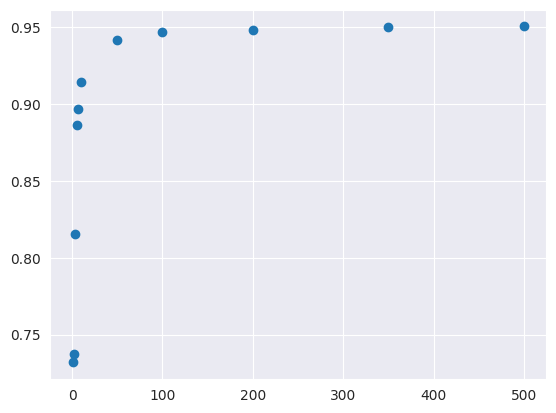

In [24]:

tree_counts = [1, 2, 3, 5, 7, 10, 50, 100, 200, 350, 500]
scores = []
for tree_count in tree_counts:
    rfc = RandomForestClassifier(n_estimators=tree_count, max_features=int(np.sqrt(global_feature_num)))
    scores.append(np.mean(cross_val_score(rfc, X, y, cv=10, n_jobs=4)))
    
plt.plot(tree_counts, scores, 'o')


#### Зависимость от количества признаков

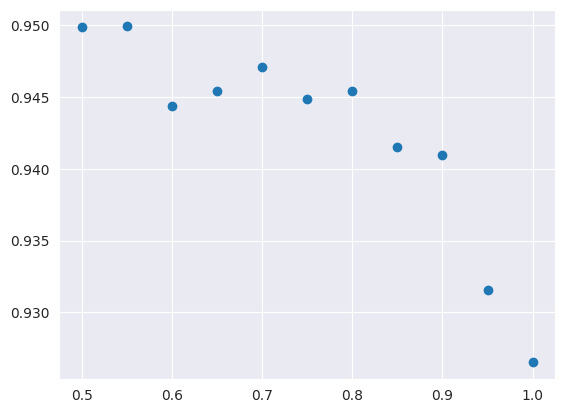

In [27]:

feature_powers = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
scores = []
for power in feature_powers:
    rfc = RandomForestClassifier(n_estimators=100, max_features=int(global_feature_num ** power))
    scores.append(np.mean(cross_val_score(rfc, X, y, cv=10, n_jobs=4)))
    
plt.plot(feature_powers, scores, 'o')


#### Зависимость от глубины деревьев

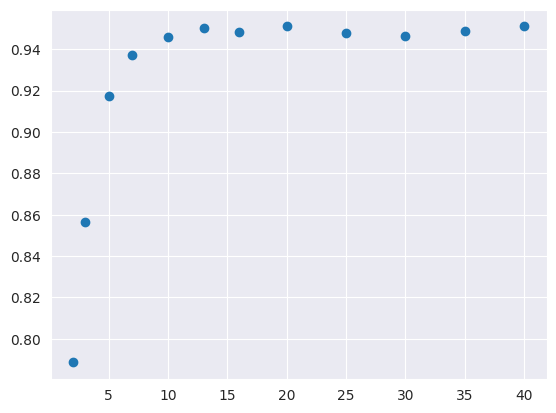

In [28]:

depths = [2, 3, 5, 7, 10, 13, 16, 20, 25, 30, 35, 40]
scores = []
for depth in depths:
    rfc = RandomForestClassifier(n_estimators=100, max_features=int(global_feature_num ** 0.5), max_depth=depth)
    scores.append(np.mean(cross_val_score(rfc, X, y, cv=10, n_jobs=4)))

plt.plot(depths, scores, 'o')
